# 4.3 Item Response Theory (IRT)



In [1]:
# Imports
import numpy as np
import pandas as pd
from rpy2 import robjects as ro
from rpy2.robjects import pandas2ri, numpy2ri
from rpy2.robjects.packages import importr

# Miscellaneous
pandas2ri.activate()
numpy2ri.activate()
ro.r('set.seed(123)')
%load_ext rpy2.ipython

# R imports
importr('base')
importr('mirt')
importr('MPsychoR')
importr('Gifi')
importr('psych')
importr('stats')
importr('eRm')
importr('ltm')

# Load the data
ro.r("data(zareki)")
zareki = pandas2ri.rpy2py(ro.globalenv['zareki'])
zarsub = zareki.loc[:, zareki.columns.str.startswith("subtr")]
zarsub2 = zarsub.drop("subtr5", axis=1)
zarsub3 = zarsub.drop("subtr1", axis=1)

# Convert to R data frames
ro.globalenv['zarsub'] = zarsub
ro.globalenv['zarsub2'] = zarsub2
ro.globalenv['zarsub3'] = zarsub3

c:\Users\maku1542\AppData\Local\miniconda3\envs\psy126\Lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


## 2. The Rasch model

The Rasch model can be used if we aim to construct a scale
that fulfills highest measurement standards. Using the Rasch Model, we model the probability that person *X* scores 1 on item *i*. Each item gets its individual item location parameter $β_i$. Within the context of ability tests, $β_i$ is often referred to as item easiness parameter.
Correspondingly, −$β_i$ is the item difficulty parameter. Each person gets a person
parameter $θ_v$, often called person ability parameter, which is obtained in a second
estimation step. Both the β’s and the θ’s are on an interval scale and can be mapped
on the same latent trait (i.e., they are directly comparable). 

The Rasch model has three fundamental assumptions:

* unidimensionality of the latent trait,
* parallel item characteristic curves (ICCs),
* local independence.

Unidimensionality was covered in detail in the section above. ICCs in conjunction
with parallel shifts will be explained further below, after fitting the Rasch model.
Local independence means that given a person parameter, item responses become
independent. This assumption is difficult to check and often omitted in practice.

Let us fit a Rasch model on the ZAREKI-R subtraction items from above. If
these data fit the Rasch model, all three assumptions can be considered as fulfilled.
In R, Rasch models can be computed using the `eRm` package (Mair and Hatzinger,
2007b) which uses a conditional maximum likelihood (CML) approach. 

The function for fitting the rashmodel is `RM()` and as argument it only requires
the data with which we want to fit the model. Have a look at the output: 

In [3]:
fitrasch1 = ro.r("RM(zarsub)")
print(fitrasch1)


Results of RM estimation: 

Call:  RM(X = zarsub) 

Conditional log-likelihood: -646.9202 
Number of iterations: 12 
Number of parameters: 7 

Item (Category) Difficulty Parameters (eta):
             subtr2    subtr3     subtr4    subtr5    subtr6    subtr7
Estimate -0.7552998 1.6808330 -0.4774069 -0.280543 0.4163264 1.5508677
Std.Err   0.1619354 0.1310474  0.1515977  0.145557 0.1316531 0.1296646
             subtr8
Estimate -0.1884142
Std.Err   0.1430739





This model call fits the item parameters only. In the print output, the item
parameters are called *η*. There seems to be one parameter missing: the one for `subtr1`. This is due to the fact that there is a restriction involved in the estimation, in
order to make the model identifiable. The full vector of *β* parameters for all items
can be obtained via a multiplication with a design matrix *W* which is constructed
internally (i.e., *β = Wη*). In order to extract the entire set of easiness parameters, we can say:

In [4]:
# Get beta parameters
betapar = ro.r["coef"](fitrasch1)
rounded_sorted = np.sort(np.round(-betapar, 3))

print(rounded_sorted)

[-1.946 -0.755 -0.477 -0.281 -0.188  0.416  1.551  1.681]


Here we can now see the difficulty parameters, sorted from the easiest to the most difficult item.

### Assessing general model fit

Still, we need to verify whether the model fits, otherwise the interpretation of
these parameters is meaningless. A good strategy is to apply the LR-test proposed by
Andersen (1973), which is based on the following idea. Rasch measurement implies
that the item parameters have to be invariant across person subgroups (measurement
invariance). Therefore, for the Rasch model to fit, the item parameters based on
separate subgroup fits have to be approximately the same. This needs to hold for
any subgroup split. For instance, we can split the sample according to a median
or mean split based on the number of items solved or, even better, perform the split
according to one or multiple binary covariates. Here we use time as external splitting
variable (fast vs. slow according to a median split):

In [5]:
# Get Median
median_time = zareki["time"].median()

# Create list to store category labels
time_labels = []
for t in zareki["time"]:
    if t > median_time:
        time_labels.append("fast")
    else:
        time_labels.append("slow")

# Create categorical variable
timecat = pd.Categorical(time_labels, categories=["fast", "slow"])

print(timecat)

['fast', 'fast', 'fast', 'fast', 'fast', ..., 'slow', 'slow', 'slow', 'slow', 'slow']
Length: 341
Categories (2, object): ['fast', 'slow']


In [6]:
# Put variables into R
ro.globalenv['fitrasch1'] = fitrasch1
ro.globalenv['timecat'] = timecat

# LR Test
fitLR = ro.r("LRtest(fitrasch1, timecat)")
print(fitLR)


Andersen LR-test: 
LR-value: 24.097 
Chi-square df: 7 
p-value:  0.001 




It gives a significant result which implies that the likelihoods differ across the two groups. The model does not fit. Which item is responsible for the misfit? We can explore this question in detail using a Wald test with the same split criterion.

### Assessing misfit at the item level

In [7]:
# Wald test
fitWalt1 = ro.r("Waldtest(fitrasch1, timecat)")
print(fitWalt1)


Wald test on item level (z-values):

            z-statistic p-value
beta subtr1      -0.360   0.719
beta subtr2       0.237   0.813
beta subtr3      -2.342   0.019
beta subtr4       0.730   0.465
beta subtr5       4.199   0.000
beta subtr6      -0.548   0.584
beta subtr7      -1.529   0.126
beta subtr8      -0.469   0.639




Here, we can use the magnitudes of the p-values to judge the degree of misfit and
come to the conclusion that subtr5, already suspicious in the Princals solution
above, is most responsible for the misfit. A graphical illustration reflecting this
deviation can be produced as follows:

In [8]:
# Put variable into R
ro.globalenv['fitLR'] = fitLR

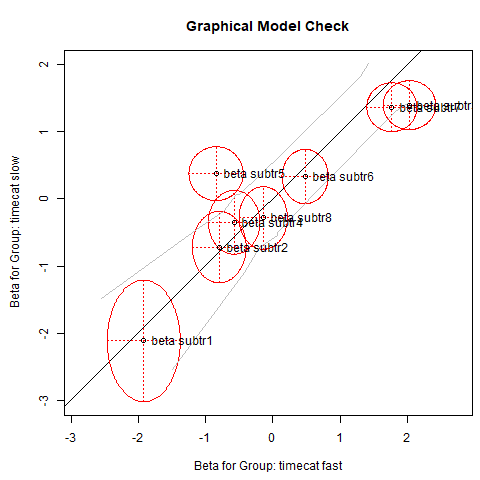

In [9]:
%%R
plotGOF(fitLR, ctrline = list(col = "gray"), conf = list())

If the parameters were exactly the same across the
two subsamples, they would lie on the diagonal, and the model would fit. The gray
lines reflect the confidence bands around the diagonal. The 95% confidence ellipses
for the item parameters are shown in red. We see that subtr5 is clearly outside
the confidence band, and we have good evidence for eliminating it. We are going to
refit the model without this item, apply the LR-test once more, and check whether
the Rasch model fits.

### Refit the model with only well fitting items
Make a new model only including valid items and test it using the `LRtest()` function. 

In [10]:
# Fit the model
fitrasch2 = ro.r("RM(zarsub2)")
print(fitrasch2)

# Put variable into R
ro.globalenv['fitrasch2'] = fitrasch2

# LR Test
fitLR2 = ro.r("LRtest(fitrasch2, timecat)")
print(fitLR2)

# Wald Test
fitWalt2 = ro.r("Waldtest(fitrasch2, timecat)")
print(fitWalt2)

# Put variable into R
ro.globalenv['fitLR2'] = fitLR2


Results of RM estimation: 

Call:  RM(X = zarsub2) 

Conditional log-likelihood: -505.4673 
Number of iterations: 11 
Number of parameters: 6 

Item (Category) Difficulty Parameters (eta):
             subtr2    subtr3     subtr4    subtr6    subtr7     subtr8
Estimate -0.8262491 1.7167464 -0.5403677 0.3872352 1.5805609 -0.2422317
Std.Err   0.1637810 0.1362896  0.1536065 0.1347287 0.1346704  0.1453549




Andersen LR-test: 
LR-value: 5.715 
Chi-square df: 6 
p-value:  0.456 



Wald test on item level (z-values):

            z-statistic p-value
beta subtr1       0.128   0.898
beta subtr2       0.806   0.420
beta subtr3      -1.855   0.064
beta subtr4       1.323   0.186
beta subtr6       0.031   0.975
beta subtr7      -1.025   0.306
beta subtr8       0.117   0.907




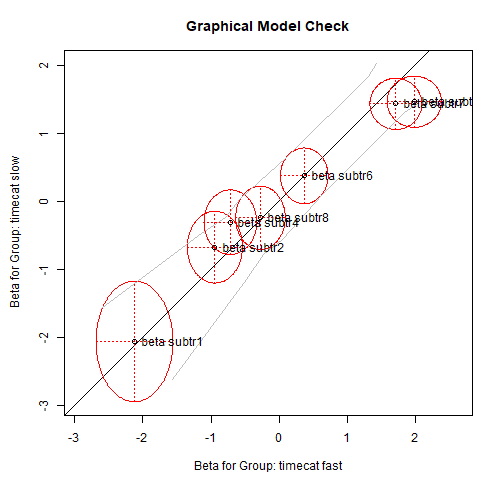

In [11]:
%%R
plotGOF(fitLR2, ctrline = list(col = 'gray'), conf = list())

### Interpretation
The nonsignificant p-value suggests that the model fits.
In practice, it is suggested to run these tests on multiple external binary
covariates. It is important to eliminate only one item at a time and then refit the
model which, of course, can be tedious in cases where many items need to be
eliminated. If you are curious, the `eRm` package provides the convenience function `stepwiseIt`
which eliminates items until a particular test of choice fits.

### Item-specific local independence (T1-test) local independence at a global level (T11-test)

It has been shown in simulation studies (Suárez-Falcón and Glas, 2003) that the
LR-test works well for detecting violations of unidimensionality and parallel ICC
violations. Based on the nonsignificant result from above, we can conclude that
these assumptions are not violated. If we want to test assumptions more explicitly,
the nonparametric testing framework proposed by Ponocny (2001) provides a
large amount of testing possibilities. The `eRm` package uses the `RaschSampler`
package (Verhelst et al., 2007) internally determine to compute the test statistics.
As an example, we examine *item-specific local independence* (T1-test) and *local independence at a global level* (T11-test).

In [12]:
# Drop not wanted columns
zarsub4 = zarsub.drop(zarsub.columns[4], axis=1)

# Put variable into R
ro.globalenv['zarsub4'] = zarsub4

# T1-test
T1 = ro.r("NPtest(as.matrix(zarsub4), n=1000, method='T1')")
print(T1)

# T11-test
T11 = ro.r("NPtest(as.matrix(zarsub4), n=1000, method='T11')")
print(T11)

Nonparametric RM model test: T1 (local dependence - increased
    inter-item correlations)
    (counting cases with equal responses on both items)
Number of sampled matrices: 1000 
Number of Item-Pairs tested: 21 
Item-Pairs with one-sided p < 0.05 
none


Nonparametric RM model test: T11 (global test - local dependence)
(sum of deviations between observed and expected inter-item
    correlations)
Number of sampled matrices: 1000 
one-sided p-value: 0.893 




The first output suggests that none of the item pairs show significant local
dependence. The second test output confirms this result by telling us that local
independence holds at a global level (see not-significant p-value).

### Interpret item parameters

At this point we can conclude that our data fit the Rasch model. This gives our
scale the highest seal of approval. Thus, we can interpret the item parameters and,
finally, elaborate on what (parallel) ICCs are.
To do so, use the Rash model fited on only the valid items and print the parameters
in a sorted manner: 

In [13]:
# Fit the model
fitrasch3 = ro.r("RM(zarsub2)")
print(fitrasch3)

# Put variable into R
ro.globalenv['fitrasch3'] = fitrasch3

# Get beta parameters
betapar = ro.r["coef"](fitrasch3)
rounded_sorted = np.sort(np.round(-betapar, 3))

print(rounded_sorted)


Results of RM estimation: 

Call:  RM(X = zarsub2) 

Conditional log-likelihood: -505.4673 
Number of iterations: 11 
Number of parameters: 6 

Item (Category) Difficulty Parameters (eta):
             subtr2    subtr3     subtr4    subtr6    subtr7     subtr8
Estimate -0.8262491 1.7167464 -0.5403677 0.3872352 1.5805609 -0.2422317
Std.Err   0.1637810 0.1362896  0.1536065 0.1347287 0.1346704  0.1453549



[-2.076 -0.826 -0.54  -0.242  0.387  1.581  1.717]


### Plot ICC

You might notice that the item difficulties directly correspond to the intercepts in the plot below. Lower item difficulties (e.g. item 1) therefore go along with a higher probability to score (and vice versa).

ICCs, sometimes also called item response functions, determine the item behavior
(i.e., endorsement probability) along the latent trait.

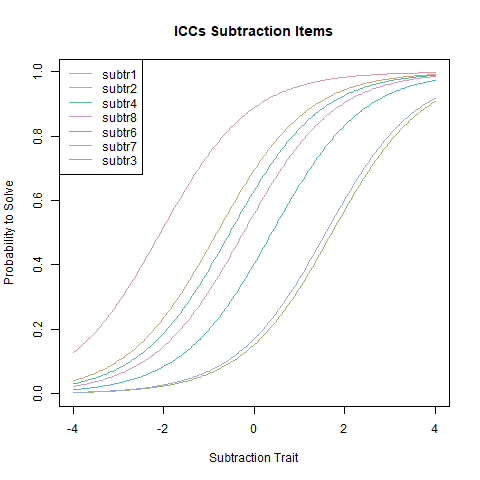

In [14]:
%%R
plotjointICC(fitrasch3, xlab = 'Subtraction Trait', main = 'ICCs Subtraction Items')

First of all, we see that all ICCs are parallel, and all of them have a slope of 1.
This is an implication of the Rasch model which will be relaxed in the next section.
The plot shows that `subtr1` is the easiest item, since it is located furthest to the left
on the trait, meaning that it is the item that requires the lowest amount of latent train to have a probability of being scored correctly of 1. `subtr3` is to the far right and consequently the most difficult one. In
this plot, the item parameters are reflected the value on the x-axis for which the
endorsement probability is exactly 0.5. In the plot, this is demonstrated for `subtr3`.

### Estimate person parameter

Once the model fits, we can estimate the person parameter in a second step:

In [15]:
zarppar = ro.r("person.parameter(fitrasch2)")
print(zarppar)


Person Parameters:

 Raw Score   Estimate Std.Error
         0 -3.4339847        NA
         1 -2.2893324 1.1743143
         2 -1.2100273 0.9467207
         3 -0.3879450 0.8812713
         4  0.3846573 0.8862733
         5  1.2190514 0.9524210
         6  2.2958672 1.1656079
         7  3.4334872        NA



Each individual gets its own person parameter. Children who answered the same
number of items correctly will get the same person parameter. They are mapped on
the same latent trait as the items. 

**Raw Score**: This column represents the observed raw scores on the test or assessment. These are the total number of correct responses each person obtained on the test. 

**Estimate**: This column represents the estimated person parameters for each raw score. The person parameters indicate the latent trait or ability level of individuals on the underlying construct being measured by the test. In the Rasch model, these estimates are usually expressed in log-odds units, also known as logits. 

**Std.Error**: This column represents the standard error associated with each person parameter estimate. It indicates the precision or reliability of the estimate. A lower standard error suggests a more precise estimate. 

For instance, for individuals with a raw score of 0 (meaning they got no items correct), the estimated person parameter is approximately -3.43 logits. This suggests that individuals who scored 0 on the test are estimated to have lower ability levels on the subtraction trait being measured.
Conversely, individuals with higher raw scores have higher estimated person parameters, indicating higher ability levels on the underlying trait.
Standard errors are not provided for extreme raw scores (0 and 7), due to non-estimability at the extremes. This is not an error but a mathematical property of maximum likelihood estimation (MLE) in Rasch models. See [this link](https://www.rasch.org/rmt/rmt122h.htm) for more information on how to circumvent this limitation.


### Add person parameters to the data matrix and use them in further analyses

The person parameters can be added to the data matrix and used for further
statistical analysis as metric variable. Here we show an ANOVA with school year as
factor (three levels).

In [19]:
zareki = zareki.rename(columns={'class': 'school_class'}) # Rename 'class' to something else, as it is a reserved keyword in Python (this would later cause issues in statsmodels)

# Get the theta table (still an R data frame)
theta_table = zarppar.rx2("theta.table")

# Extract the "Person Parameter" column as an R vector
theta_vector = theta_table.rx2("Person Parameter")  # This is an R FloatVector

# Convert it directly to a NumPy array or list
theta_values = list(theta_vector)  # Or use np.array(theta_vector) if you're working with NumPy

# Add it to the DataFrame
zareki['theta'] = theta_values

print(zareki.head())


   addit1  addit2  addit3  addit4  addit5  addit6  addit7  addit8  subtr1  \
1     1.0     1.0     1.0     1.0     1.0     1.0     1.0     0.0     1.0   
2     1.0     1.0     1.0     1.0     0.0     1.0     1.0     0.0     1.0   
3     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
4     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
5     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   

   subtr2  subtr3  subtr4  subtr5  subtr6  subtr7  subtr8  school_class  time  \
1     1.0     1.0     1.0     1.0     1.0     0.0     1.0             1  39.0   
2     1.0     1.0     1.0     1.0     1.0     0.0     1.0             1  37.0   
3     1.0     0.0     1.0     1.0     0.0     0.0     1.0             1  34.0   
4     1.0     0.0     1.0     1.0     0.0     1.0     1.0             1  28.0   
5     1.0     0.0     1.0     1.0     0.0     0.0     1.0             1  32.0   

      theta  
1  2.295867  
2  2.295867  
3  0.384

In [20]:
# Ensure that the column "class" is treated as a categorical variable.
zareki['school_class'] = zareki['school_class'].astype('category')

import statsmodels.formula.api as smf
import statsmodels.api as sm

# Fit the model and perform the ANOVA
model = smf.ols('theta ~ school_class', data=zareki).fit()

anova_table = sm.stats.anova_lm(model)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
school_class,2.0,129.103094,64.551547,31.795033,2.226393e-13
Residual,338.0,686.221107,2.030240,NaN,NaN


The result suggests significant differences in ability across the 3 years. Still, the
subtraction scale is *fair* since the Rasch model holds: *fairness* is a property of the
item parameters, and not a person parameter property.

---

An important contribution to the Rasch ecosystem was the idea to embed Rasch
models into a mixed-effects models framework. To be more precise, Rasch models
are nothing else than mixed-effects logistic regressions with, in their most basic
form, items as fixed effects and persons as random effects. The random intercepts
correspond to the person parameters, the fixed effect parameters to the item location
parameters. This idea of explanatory item response models adds many modeling
possibilities (see De Boeck et al., 2011, for details).

## 3. Two-parameter logistic model

The parallel ICC assumption involving constant slope parameters of 1 is a rather
strict one. One-parameter logistic model versions of Rasch (called 1-PL or OPLM) relax this assumption slightly by estimating a single item discrimination parameter
α, generally different from 1. Still, the ICCs are parallel. This idea represents a
different philosophical measurement perspective. Under the Rasch paradigm, we
modify the data such that it fits the Rasch model. Under the 1-PL and the other
models presented in this section, we try to find a model that fits our data. 

In practice, the two-parameter logistic model (2-PL Birnbaum, 1968) is more
relevant than the 1-PL. It estimates an item discrimination parameter *αi* for each
item individually, which allows the ICCs to cross. Compared to the Rasch model, it relaxes the assumption of parallel ICCs through
$α_i$ , while unidimensionality and local independence still need to hold.

### The dataset

The dataset we use to illustrate the 2-PL is taken from Mair et al. (2015). In this
study, the authors were interested in finding out why package developers contribute
to R. Among other things, they presented three subscales of the Work Design
Questionnaire (WDQ) by Morgeson and Humphrey (2006), in order to explore
whether certain work design characteristics had an influence on the participation
in package developments. In our little IRT application below, the main interest is
not to remove many items in order to achieve a strong measurement instrument.
Rather, the main objective is to score the developers and only remove items that are
heavily misfitting. Hence, we use a more flexible 2-PL since a Rasch model might
be too strict. We consider a single WDQ subscale only: “knowledge characteristics” which
includes 18 dichotomous items related to job complexity, information processing,
problem solving, skill variety, and specialization.

### Load & inspect the data

In [21]:
# Load the data in R
ro.r("data(RWDQ)")

# Get as DataFrame
RWDQ = pandas2ri.rpy2py(ro.globalenv['RWDQ'])

RWDQ.head()


,wdq_22,wdq_23,wdq_24,wdq_25,wdq_26,wdq_27,wdq_28,wdq_29,wdq_30,wdq_31,wdq_32,wdq_33,wdq_34,wdq_35,wdq_36,wdq_37,wdq_38,wdq_39
1,1.0,1.0,1.0,1.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
5,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6,0.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### Fit the model

We use the `ltm()` function from the `ltm` R package to fit a two-parameter logistic (2PL) model, specifying a single latent dimension with `z1`.

In [ ]:
# Fit the model
fit2pl1 = ro.r("ltm(RWDQ ~ z1)")
print(fit2pl1)


Call:
ltm(formula = RWDQ ~ z1)

Coefficients:
        Dffclt  Dscrmn
wdq_22  -9.490   0.124
wdq_23   1.067  -0.732
wdq_24   0.389  -0.816
wdq_25   1.456  -1.561
wdq_26   2.125  -0.664
wdq_27   0.571  -1.153
wdq_28   1.136  -0.811
wdq_29   2.288  -1.297
wdq_30   1.835  -0.857
wdq_31   0.748  -0.926
wdq_32   0.773  -0.822
wdq_33   2.513  -1.709
wdq_34   2.385  -1.339
wdq_35   3.136  -0.967
wdq_36   1.365  -1.041
wdq_37   1.116  -1.176
wdq_38   0.788  -2.696
wdq_39   1.150  -1.970

Log.Lik: -7648.692




The first column contains the item difficulty parameters $β_i$ . Since the construct
is knowledge characteristics, speaking about difficulty does not make sense. A
large $β_i$ simply means that the item is located at the upper end of the knowledge
characteristics continuum. That is, it allows us to discriminate among persons
with high-knowledge characteristics. Conversely, a low item parameter measures
knowledge characteristics at its lower end and, correspondingly, discriminates
among persons with low knowledge characteristic. The second column shows the
item discrimination parameters *αi* which reflect the varying ICC slopes. 

In the print output above, the item location parameter of item 22 (first row) is
unreasonably low, compared to the other parameters. Reasons for such a heavily
outlying parameter are that either the algorithm did not converge or the item violates
an assumption. Plotting a Princals solution on this dataset (not shown here), suggests
that item 22 deviates strongly from the remaining ones. Thus, let us eliminate
wdq_22 and refit the 2-PL model.

### Refit after eliminating wdq_22

In [26]:
# Drop item wdq_22
RWDQsub = RWDQ.drop("wdq_22", axis=1)

# Put variable into R
ro.globalenv['RWDQsub'] = RWDQsub

# Fit the model
fit2pl2 = ro.r("ltm(RWDQsub ~ z1)")
print(fit2pl2)


Call:
ltm(formula = RWDQsub ~ z1)

Coefficients:
        Dffclt  Dscrmn
wdq_23  -1.064   0.736
wdq_24  -0.387   0.822
wdq_25  -1.456   1.561
wdq_26  -2.113   0.668
wdq_27  -0.570   1.157
wdq_28  -1.138   0.808
wdq_29  -2.281   1.303
wdq_30  -1.835   0.858
wdq_31  -0.748   0.925
wdq_32  -0.775   0.819
wdq_33  -2.506   1.716
wdq_34  -2.382   1.341
wdq_35  -3.132   0.968
wdq_36  -1.368   1.038
wdq_37  -1.118   1.173
wdq_38  -0.789   2.678
wdq_39  -1.151   1.967

Log.Lik: -7090.504




### Explore item fit

Let us do a final itemfit check by computing a $χ^2$-based itemfit statistic called Q1, following Yen (1981). In general,
a significant p-value suggests that the item does not fit. 

For each item:
- Null hypothesis (H₀): The item fits the model.
- Alternative (H₁): The item does not fit the model.

If the p-value is low (p-value < 0.05), you reject H₀, meaning that the item may not fit the model well.

But based on the fact that the Q1 statistic exhibits inflated Type I error rates and other (not mentioned) considerations regarding scale construction vs. evaluation, we do not have to use these p-values as our only criterion to keep or eliminate items.

In [27]:
# Put variable into R
ro.globalenv['fit2pl2'] = fit2pl2
# Run item.fit()
itemfit = ro.r("item.fit(fit2pl2)")
print(itemfit)


Item-Fit Statistics and P-values

Call:
ltm(formula = RWDQsub ~ z1)

Alternative: Items do not fit the model
Ability Categories: 10

           X^2 Pr(>X^2)
wdq_23  7.2445   0.5105
wdq_24  0.0000        1
wdq_25  0.0000        1
wdq_26  0.0000        1
wdq_27  0.0000        1
wdq_28  0.0000        1
wdq_29  0.0000        1
wdq_30  4.2489    0.834
wdq_31  0.0000        1
wdq_32  6.8452   0.5534
wdq_33  0.0000        1
wdq_34 13.9219   0.0838
wdq_35 10.5261     0.23
wdq_36  4.6761   0.7916
wdq_37  0.0000        1
wdq_38  0.0000        1
wdq_39  9.4313   0.3072





The results suggest that the entire set of items fits; none of the
p-values is significant. Thus, no further item elimination steps are needed.

### Explore the ICCs

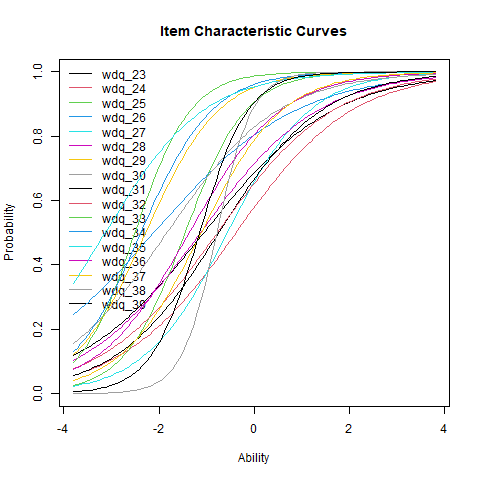

In [28]:
%%R
plot(fit2pl2, legend=TRUE)

Compared to the Rasch model, the striking difference is that the 2-PL ICCs are
allowed to cross. Item locations can be displayed in the same way as in the Rasch
model: think of a horizontal line at p = 0.5, and then drop vertical lines down to the
x-axis from where it intersects with the ICC. We see that wdq_25 has the largest
discrimination parameter, leading to the steepest ICC slope.

### Explore the discrimination parameters

In [31]:
# Get the discrimination coefficients for the first 5 items (column 2)
disc_coeffs_r = ro.r("sort(round(coef(fit2pl2)[1:5, 2], 3))") #Column 2 is the discrimination parameter
diff_coeffs_r = ro.r("sort(round(coef(fit2pl2)[1:5, 1], 3))") #Column 1 is the difficulty parameter

# Convert to NumPy array for easier handling
disc_coeffs = np.array(disc_coeffs_r)
diff_coeffs = np.array(diff_coeffs_r)

# Print shape and content
print(f"📐 Shape of discrimination coefficients array: {disc_coeffs.shape}")
print("🎯 Sorted Discrimination Coefficients (first 5 items):")
print(disc_coeffs)

print()

print(f"📐 Shape of difficulty coefficients array: {diff_coeffs.shape}")
print("🎯 Sorted Difficulty Coefficients (first 5 items):")
print(diff_coeffs)

📐 Shape of discrimination coefficients array: (5,)
🎯 Sorted Discrimination Coefficients (first 5 items):
[0.668 0.736 0.822 1.157 1.561]

📐 Shape of difficulty coefficients array: (5,)
🎯 Sorted Difficulty Coefficients (first 5 items):
[-2.113 -1.456 -1.064 -0.57  -0.387]


“Good” discrimination parameters are typically in the range from 0.8 to 2.5 (de
Ayala, 2009), and within this range we prefer items with higher discrimination. 
Outside this range, the ICCs are either too flat (such items do not
discriminate well along the entire continuum) or too steep (such items discriminate
only within a very narrow trait range). One can see again that wdq_25 has the largest
discrimination parameter.

### Estimate person parameters

Since the 2-PL fits, we can compute the person parameters.

In [32]:
ppars = ro.r("factor.scores(fit2pl2, resp_patterns=RWDQsub)$score.dat[, 'z1']")
print(ppars[:5])

[-2.55273404 -2.20716547 -1.84482957 -0.94047876 -1.36764477]


## 4. Three-parameter logistic model

Let us add another parameter which brings us to the three-parameter
logistic model (3-PL; Birnbaum, 1968). The new parameter $γ_i$ reflects the probability of a 1-response on item i due to chance
alone and is often referred to as pseudo-guessing parameter. With respect to the
ICCs, it reflects a lower asymptote parameter. That is, even someone with infinite
low ability has a certain probability to score 1 on item i. These probabilities vary
across items. With the 3-PL, we create a model that is even more flexible than the
2-PL, but still, unidimensionality and local independence need to be fulfilled.

### The dataset

To illustrate a 3-PL model fit, we reproduce some of the analyses carried out
in Wilmer et al. (2012). Within the context of a face recognition experiment, they
presented the Verbal Paired-Associates Memory Test (VPMT; Woolley et al., 2008)
to the participants. The authors used a 3-PL since their main goal was to score the
persons, rather than being strict on the item side in terms of eliminating items. Let
us load the dataset and extract the 25 VPMT items.

### Load and inspect the data

Before fitting the model we need to drop the first columns as it is not related to items responses.

In [33]:
# Load the data
ro.r("data(Wilmer)")

# Get as DataFrame
Wilmer = pandas2ri.rpy2py(ro.globalenv['Wilmer'])

# Drop the first two columns
VPMT = Wilmer.drop(Wilmer.columns[0:2], axis=1)

# Put bariable into R
ro.globalenv['VPMT'] = pandas2ri.py2rpy(VPMT)

### Fit the model

In [ ]:
fit3pl = ro.r("tpm(VPMT)")

# Put bariable into R
ro.globalenv['fit3pl'] = pandas2ri.py2rpy(fit3pl)

print(fit3pl)


Call:
tpm(data = VPMT)

Coefficients:
        Gussng  Dffclt  Dscrmn
vpmt1    0.071  -0.216   1.531
vpmt2    0.280   1.020   1.736
vpmt3    0.384   1.527   1.763
vpmt4    0.103   0.470   1.264
vpmt5    0.023  -0.299   1.247
vpmt6    0.135   0.504   1.192
vpmt7    0.229   0.747   1.702
vpmt8    0.238   0.679   1.412
vpmt9    0.278   1.350   1.584
vpmt10   0.233   0.248   1.588
vpmt11   0.271   0.840   1.360
vpmt12   0.264   0.754   2.173
vpmt13   0.296   1.513   2.466
vpmt14   0.191   1.889   1.455
vpmt15   0.183   0.660   1.374
vpmt16   0.088   0.319   1.561
vpmt17   0.386   0.590   2.500
vpmt18   0.214   0.629   1.705
vpmt19   0.193   0.792   1.579
vpmt20   0.264   0.362   1.965
vpmt21   0.178   0.725   2.278
vpmt22   0.167   1.091   2.774
vpmt23   0.295   0.788   1.973
vpmt24   0.235   0.641   1.607
vpmt25   0.180   0.743   1.769

Log.Lik: -23078.57




In addition to the item locations and the discrimination parameters, we get
pseudo-guessing parameters.

### Explore the ICCs

The ICCs for the first six items can be plotted as follows:

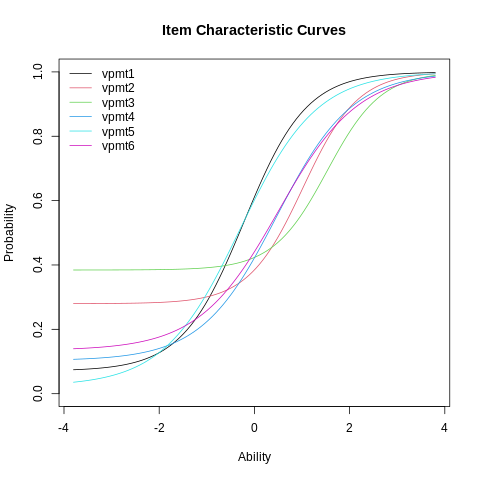

In [ ]:
%%R
plot(fit3pl, item=1:6, legend=TRUE)

We see the effect of the γ -parameters in
terms of lower ICC asymptotes. Item 3 has the largest pseudo-guessing parameter.
As in the 2-PL, the ICCs are allowed to cross due to the α’s in the model.